In [1]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import layers, models
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.callbacks import LearningRateScheduler
import matplotlib.pyplot as plt
import os

In [3]:
def class_valid_cek():
    column = ['Apple Fresh', 'Apple Rotten', 'Apple Semifresh', 'Apple Semirotten',
              'Banana Fresh', 'Banana Rotten', 'Banana Semifresh', 'Banana Semirotten',
              'Orange Fresh', 'Orange Rotten', 'Orange Semifresh', 'Orange Semirotten']
    subfolder = ['train', 'valid']

    for sub in subfolder:
        print(f"\nClass {sub} \n")
        for col in column:
            data_dir = f'./Dataset/{sub}/{col}'
            print(f"Total {sub} {col} image: {len(os.listdir(data_dir))}")

class_valid_cek()


Class train 

Total train Apple Fresh image: 298
Total train Apple Rotten image: 243
Total train Apple Semifresh image: 83
Total train Apple Semirotten image: 205
Total train Banana Fresh image: 72
Total train Banana Rotten image: 228
Total train Banana Semifresh image: 711
Total train Banana Semirotten image: 121
Total train Orange Fresh image: 105
Total train Orange Rotten image: 137
Total train Orange Semifresh image: 79
Total train Orange Semirotten image: 72

Class valid 

Total valid Apple Fresh image: 129
Total valid Apple Rotten image: 105
Total valid Apple Semifresh image: 36
Total valid Apple Semirotten image: 89
Total valid Banana Fresh image: 32
Total valid Banana Rotten image: 98
Total valid Banana Semifresh image: 305
Total valid Banana Semirotten image: 53
Total valid Orange Fresh image: 46
Total valid Orange Rotten image: 60
Total valid Orange Semifresh image: 34
Total valid Orange Semirotten image: 31


In [6]:
def train_val_generators(TRAINING_DIR, VALIDATION_DIR):

  tf.random.set_seed(42)

  train_datagen = ImageDataGenerator(
                    rescale=1./255,
                    shear_range=0.2,
                    zoom_range=0.2,
                    horizontal_flip=True,
                    vertical_flip=True,
                    rotation_range=0.2,
                    fill_mode='nearest' 
                )

  train_generator = train_datagen.flow_from_directory(directory=TRAINING_DIR,
                                                      batch_size=32,
                                                      class_mode='categorical',
                                                      target_size=(224, 224),
                                                      seed=42)

  validation_datagen = ImageDataGenerator(rescale = 1./255)

  validation_generator = validation_datagen.flow_from_directory(directory=VALIDATION_DIR,
                                                                batch_size=32,
                                                                class_mode='categorical',
                                                                target_size=(224, 224),
                                                                seed=42)
  return train_generator, validation_generator

In [7]:
TRAINING_DIR = "./dataset/train/"
VALIDATION_DIR = "./dataset/valid/"
train_generator, validation_generator = train_val_generators(TRAINING_DIR, VALIDATION_DIR)

Found 2354 images belonging to 12 classes.
Found 1018 images belonging to 12 classes.


In [8]:
def lr_scheduler(epoch, learning_rate):
    if epoch < 10:
        return learning_rate
    else:
        return learning_rate * tf.math.exp(-0.1)

In [9]:
def create_model():
    base_model = tf.keras.applications.MobileNetV2(input_shape=(224, 224, 3),
                                               include_top=False,
                                               weights='imagenet')
    
    for layer in base_model.layers:
        layer.trainable = False
    
    model = models.Sequential([
        base_model,
        layers.Conv2D(256, (3, 3), activation='relu', padding='same'),
        layers.GlobalAveragePooling2D(),
        layers.Dense(256, activation='relu'),
        layers.Dropout(0.2),
        layers.Dense(128, activation='relu'),
        layers.Dropout(0.2),
        layers.Dense(12, activation='softmax')
    ])
    model.compile(optimizer= tf.keras.optimizers.Adam(),
                loss= 'categorical_crossentropy',
                metrics=['accuracy']) 
    return model

In [10]:
model = create_model()
callback = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=5)
lr_callback = LearningRateScheduler(lr_scheduler)

model.summary()



Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 mobilenetv2_1.00_224 (Func  (None, 7, 7, 1280)        2257984   
 tional)                                                         
                                                                 
 global_average_pooling2d (  (None, 1280)              0         
 GlobalAveragePooling2D)                                         
                                                                 
 flatten (Flatten)           (None, 1280)              0         
                                                                 
 dense (Dense)               (None, 256)               327936    
                                                                 
 dropout (Dropout)           (None, 256)               0         
                                                                 
 dense_1 (Dense)             (None, 12)               

In [11]:
history = model.fit(train_generator,
                    validation_data=validation_generator,
                    epochs=20,
                    callbacks=[lr_callback,callback])

Epoch 1/20


74/74 [==============================] - 97s 1s/step - loss: 0.7821 - accuracy: 0.7566 - val_loss: 0.4601 - val_accuracy: 0.8487 - lr: 0.0010
Epoch 2/20
74/74 [==============================] - 71s 949ms/step - loss: 0.3734 - accuracy: 0.8619 - val_loss: 0.3369 - val_accuracy: 0.8900 - lr: 0.0010
Epoch 3/20
74/74 [==============================] - 69s 930ms/step - loss: 0.3125 - accuracy: 0.8900 - val_loss: 0.2970 - val_accuracy: 0.8998 - lr: 0.0010
Epoch 4/20
74/74 [==============================] - 72s 975ms/step - loss: 0.2692 - accuracy: 0.8985 - val_loss: 0.2819 - val_accuracy: 0.9047 - lr: 0.0010
Epoch 5/20
74/74 [==============================] - 76s 1s/step - loss: 0.2411 - accuracy: 0.9167 - val_loss: 0.2644 - val_accuracy: 0.9096 - lr: 0.0010
Epoch 6/20
74/74 [==============================] - 76s 1s/step - loss: 0.2182 - accuracy: 0.9227 - val_loss: 0.2503 - val_accuracy: 0.9008 - lr: 0.0010
Epoch 7/20
74/74 [==============================] - 77s 1s/step - loss:

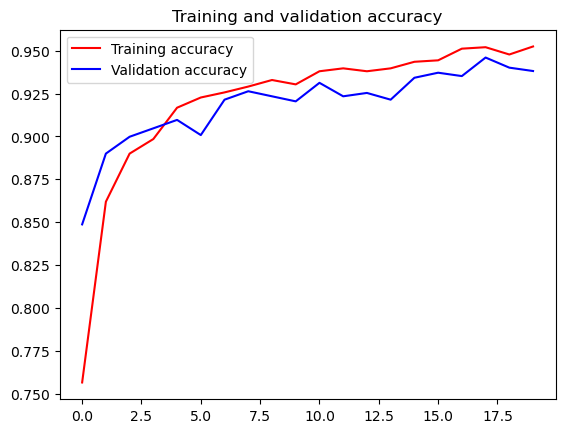

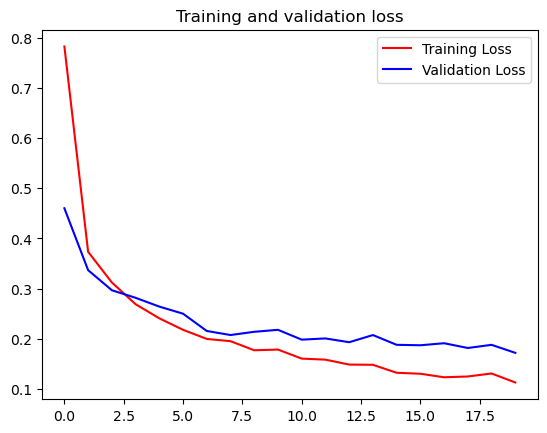

In [12]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(len(acc))
plt.plot(epochs, acc, 'r', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend()
plt.figure()
plt.plot(epochs, loss, 'r', label='Training Loss')
plt.plot(epochs, val_loss, 'b', label='Validation Loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

In [14]:
model.save('fruition_model.h5')